# **CS 1810 Homework 2**
---
To account for potential version issues, try the following in your terminal:

1. Create a new environment with `python3 -m venv venv`
2. Activate that environment with `source venv/bin/activate`
3. Make sure the interpreter in the top right corner of your VSCode (or whatever you use to run your code is venv).
4. If you get a "install kernel" message, press it.
5. Run `pip install -r requirements.txt`
6. Run the remainder of this notebook.

Note that this is not necessary but can help prevent any issues due to package versions.

**The following notebook is meant to help you work through Problems 1 and 3 on Homework 2. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib.patches as mpatches
from scipy.special import expit as sigmoid
from scipy.special import softmax
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvn
from T2_P1_TestCases import test_p1
from T2_P3_TestCases import test_p3_softmax, test_p3_knn

In [15]:
### Data for Problem 1
t_obs, y_obs = np.genfromtxt("data/planet-obs.csv", delimiter = ',').T
t_obs = np.split(t_obs, 10)
y_obs = np.split(y_obs.reshape(-1, 1), 10)

### Data for Problem 3
data = pd.read_csv("data/hr.csv")
mapper = {
    "Automatically Rejected": 0,
    "Require Guarantor": 1,
    "Automatically Accepted": 2
}
data['Type'] = data['Type'].map(mapper)
X_applicants = data[['Debt to Income Ratio', 'Credit Score']].values

# transformation as described in problem statement
def transform(X):
  X = np.stack((X[:,0]*20/0.7-7.5, X[:,1]/140 - (500/140+0.5)), axis=1)
  return X
# Transformation
X_applicants = transform(X_applicants)
y_applicants = data['Type'].values

# Problem 1

## Problem 1 Subpart 1

In [3]:
def basis1(t):
    return np.stack([np.ones(len(t)), t], axis=1)

def basis2(t):
    """
    Transform t into basis [1, t, t^2]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 3)
    """
    # creating the stack
    return np.column_stack([np.ones(len(t)), t, t**2])
    

def basis3(t):
    """
    Transform t into basis [1, t, t^2, t^3, t^4, t^5]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 6)
    """
    # creating the stack
    return np.column_stack([np.ones(len(t)), t, t**2, t**3, t**4, t**5])

#print(basis3(t))
#t = np.array([1,2,3,4,5])

In [4]:
class LogisticRegressor:
    def __init__(self, eta, runs):
        # eta = learning rate, or alpha
        # runs = number of times we run it
        self.eta = eta
        self.runs = runs
        self.W = None

    def fit(self, x, y, w_init):
        """
        Optimize the weights W to minimize the negative log-likelihood by using gradient descent

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :param y: a 2D numpy array of output values. Shape is (n x 1)
        :param w_init: a 2D numpy array that initializes the weights. Shape is (d x 1)
        :return: None
        """
        # Keep this for the autograder
        self.W = w_init
        # do gradient descent to minimize the loss
        for i in range(self.runs):
            # calculate the gradient
            grad = np.dot((self.predict(x) - y).T, x).T #3x1
            # grad = np.dot(x.T, (self.predict(x)-y))/x.shape[0]
            # n = 10, d=3

            # update self.W
            self.W = self.W - ((self.eta / x.shape[0]) * grad)
            # self.W = self.W - (self.eta * grad)
            #self.w = dx1

    def predict(self, x):
        """
        Predict classification probability of transformed input x

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :return: a 2D numpy array of predicted probabilities given current weights. Shape should be (n x 1)
        """
        return sigmoid(np.dot(x, self.W))

In [5]:
test_p1(LogisticRegressor, basis1, basis2, basis3)

Your test case results are, for basis 1, 2, and 3 respectively: Pass Pass Pass


Note: Students have reported local issues with passing the basis 3 test case. Try running on Google Colab if only basis 3 test is failing.  

## Plotting Functions for Problem 1, Subpart 2

In [17]:
# Function to visualize prediction lines
# Takes as input last_x, last_y, [list of models], basis function, title
# last_x and last_y should specifically be the dataset that the last model
# in [list of models] was trained on
def visualize_prediction_lines(last_x, last_y, models, basis, title):
    # Plot setup
    green = mpatches.Patch(color='green', label='Ground truth model')
    black = mpatches.Patch(color='black', label='Mean of learned models')
    purple = mpatches.Patch(color='purple', label='Model learned from displayed dataset')
    plt.legend(handles=[green, black, purple], loc='lower right')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Observed')
    plt.axis([0, 6, -.1, 1.1]) # Plot ranges

    # Plot dataset that last model in models (models[-1]) was trained on
    cmap = c.ListedColormap(['r', 'b'])
    plt.scatter(last_x, last_y, c=last_y, cmap=cmap, linewidths=1, edgecolors='black')

    # Plot models
    X_pred = np.linspace(0, 6, 1000)
    X_pred_transformed = basis(X_pred)

    ## Ground truth model
    plt.plot(X_pred, np.cos(1.1*X_pred + 1) * 0.4 + 0.5, 'g', linewidth=5)

    ## Individual learned logistic regressor models
    Y_hats = []
    for i in range(len(models)):
        model = models[i]
        Y_hat = model.predict(X_pred_transformed)
        Y_hats.append(Y_hat)
        if i < len(models) - 1:
            plt.plot(X_pred, Y_hat, linewidth=.3)
        else:
            plt.plot(X_pred, Y_hat, 'purple', linewidth=3)

    # Mean / expectation of learned models over all datasets
    plt.plot(X_pred, np.mean(Y_hats, axis=0), 'k', linewidth=5)

    # plt.savefig('img_output/' + title + '.png')
    plt.show()

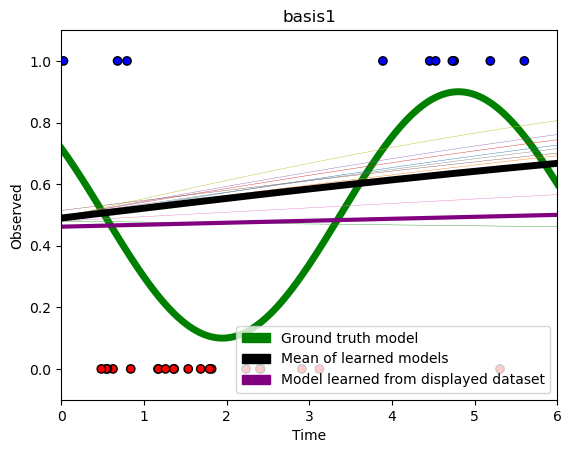

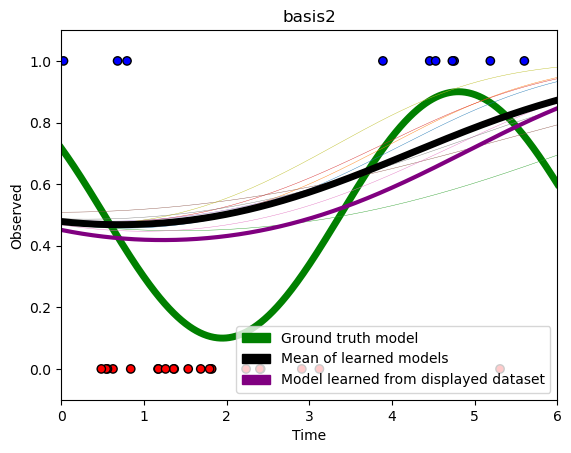

Classification probabilities for t = 0.1: 0.4991660630989407, t = 3.2: 0.9999999993074518
Model variances for t = 0.1: 0.0002814189816703252, t = 3.2: 0.08999185166565032


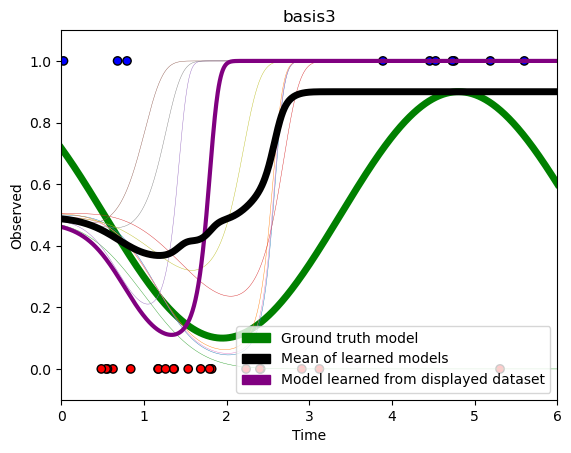

In [18]:
def plot_results(basis, title):
    # learning rate of n = 0.001, take 1000 update steps for each gradient descent run
    eta = 0.001
    runs = 1000

    # For Problem 1.4
    test_points_1 = []
    test_points_2 = []
    t1 = basis(np.array([0.1]))
    t2 = basis(np.array([3.2]))

    all_models = []
    for i in range(10):
        x, y = t_obs[i], y_obs[i]
        x_transformed = basis(x)
        model = LogisticRegressor(eta=eta, runs=runs)
        model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
        all_models.append(model)

        if basis == basis3:
            # extract values from (1 x 1) array
            pred_1 = model.predict(t1)[0, 0]
            pred_2 = model.predict(t2)[0, 0]
            if i == 0:
                print(f"Classification probabilities for t = 0.1: {pred_1}, t = 3.2: {pred_2}")
            test_points_1.append(pred_1)
            test_points_2.append(pred_2)

    if basis == basis3:
        print(f"Model variances for t = 0.1: {np.var(test_points_1)}, t = 3.2: {np.var(test_points_2)}")
    visualize_prediction_lines(x, y, all_models, basis, title)

plot_results(basis1, 'basis1')
plot_results(basis2, 'basis2')
plot_results(basis3, 'basis3')

# Problem 3

In [19]:
import numpy as np
from scipy.stats import multivariate_normal

class GaussianGenerativeModel:
    def __init__(self, is_shared_covariance=False):
        self.is_shared_covariance = is_shared_covariance
        self.means = {}
        self.covariances = {}
        self.shared_cov = None
        self.priors = {}  

    def fit(self, X, y):
        """
        Compute the means and (shared) covariance matrix of the data. Compute the prior over y.
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
        :return: None
        """
        classes = np.sort(np.unique(y)) 
        n, d = X.shape
        covariances_list = []
        
        for c in classes:
            X_c = X[y == c]
            self.means[c] = np.mean(X_c, axis=0)
            self.priors[c] = X_c.shape[0] / n
            
            cov_c = np.cov(X_c, rowvar=False, bias=False)
            if self.is_shared_covariance:
                covariances_list.append((X_c.shape[0] - 1) * cov_c) 
            else:
                self.covariances[c] = cov_c

        if self.is_shared_covariance:
            self.shared_cov = np.sum(covariances_list, axis=0) / (n - len(classes))
    
    def predict(self, X_pred):
        """
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
                 Shape should be (n,)
        """
        proba = self.predict_proba(X_pred)
        return np.argmax(proba, axis=1)

    def predict_proba(self, X_pred):
        """
        Predict class probabilities of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities.
        """
        n = X_pred.shape[0]
        classes = sorted(self.priors.keys())
        probs = np.zeros((n, len(classes)))
        
        for idx, c in enumerate(classes):
            cov = self.shared_cov if self.is_shared_covariance else self.covariances[c]
            likelihood = multivariate_normal.pdf(X_pred, mean=self.means[c], cov=cov, allow_singular=True)
            probs[:, idx] = self.priors[c] * likelihood

        probs_sum = np.sum(probs, axis=1, keepdims=True) + 1e-12
        return probs / probs_sum

    def negative_log_likelihood(self, X, y):
        """
        Given the data X, use previously calculated class means and covariance matrix to
        calculate the negative log likelihood of the data
        """
        n = X.shape[0]
        classes = sorted(self.priors.keys())
        total_ll = 0.0

        for i in range(n):
            c = y[i]
            cov = self.shared_cov if self.is_shared_covariance else self.covariances[c]
            likelihood = multivariate_normal.pdf(X[i], mean=self.means[c], cov=cov, allow_singular=True)
            total_ll += np.log(self.priors[c] * likelihood + 1e-12)

        return -total_ll
    

In [27]:
class SoftmaxRegression:
    def __init__(self, eta, lam, verbose=True):
        self.eta = eta
        self.lam = lam
        self.W = None
        self.verbose = verbose

    # Some helper functions may go here:

    def add_bias(self, X):
        """Add a column of 1s to the input features"""
        return np.hstack([np.ones((X.shape[0], 1)), X])
    
    def _one_hot(self, y, num_classes):
        """
        Convert a vector y of labels into one-hot encoded matrix.
        """
        return np.eye(num_classes)[y]

    # given functions to modify
    def fit(self, X, y):
        """
        Fit the weights W of softmax regression using gradient descent with L2 regularization
        Use the results from Problem 2 to find an expression for the gradient
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
        :return: None
        """
        X_bias = self.add_bias(X)  # (n x (d+1))
        n, d = X_bias.shape
        num_classes = np.max(y) + 1
        Y_one_hot = self._one_hot(y, num_classes)  # (n x C)
        self.W = np.zeros((d, num_classes))
        
        for it in range(200000):
            scores = np.dot(X_bias, self.W)  # (n x C)
            scores = scores - np.max(scores, axis=1, keepdims=True)
            exp_scores = np.exp(scores)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  # (n x C)
            
            # compute gradient of loss w.r.t. weights
            error = probs - Y_one_hot  # (n x C)
            grad = np.dot(X_bias.T, error) / n  # (d x C)
            # regularize weights, not bias
            grad[1:, :] += self.lam * self.W[1:, :]
            
            self.W -= self.eta * grad
                
            
    # Input is (n x 2) array
    def predict(self, X_pred):
        """
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
                 Shape should be (n,)
        """
        # YOUR CODE HERE
        X_bias = self.add_bias(X_pred)
        scores = np.dot(X_bias, self.W)
        return np.argmax(scores, axis=1)


    # Input is (n x 2) array
    def predict_proba(self, X_pred):
        """    
        Predict classification probabilities of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities (Automatically Rejected=index 0, Require Guarantor=index 1, Automatically Accepted=index 2).
                 Shape should be (n x 3)
        """
        # YOUR CODE HERE
        X_bias = self.add_bias(X_pred)
        scores = np.dot(X_bias, self.W)
        scores = scores - np.max(scores, axis=1, keepdims=True)
        exp_scores = np.exp(scores)
        probability = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probability

In [29]:
class KNNClassifier:
    def __init__(self, k):
        self.X = None
        self.y = None
        self.K = k

    # Helper functions go here: 
    def distance(self, point1, point2):
        """
        Compute the distance between two points using the specified metric:
        (debt_1 - debt_2)^2/9 + (credit_1 - credit_2)^2
        """
        return ((point1[0] - point2[0]) ** 2) / 9.0 + (point1[1] - point2[1]) ** 2
    

    # given functions to modify
    def fit(self, X, y):
        """
        In KNN, "fitting" can be as simple as storing the data, so this has been written for you.
        If you'd like to add some preprocessing here without changing the inputs, feel free,
        but this is completely optional.
        """
        self.X = X
        self.y = y

    def predict(self, X_pred_many):
        """
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
                 Shape should be (n,)
        """
        predictions = []
        for x in X_pred_many:
            # compute distances from x to all training points
            distances = np.array([self.distance(x, xi) for xi in self.X])
            # get indx
            neighbor_idx = np.argsort(distances)[:self.K]
            # get labels
            neighbor_labels = self.y[neighbor_idx]
            # get the majority vote
            counts = np.bincount(neighbor_labels)
            pred_label = np.argmax(counts)
            predictions.append(pred_label)
        return np.array(predictions)

In [30]:
def phi(X):
    """
    Transform [x_1, x_2] into basis [ln(x_1 + 10), x_2^2]

    :param t: a 2D numpy array of values to transform. Shape is (n x 2)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 2)
    """
    X_transformed = np.zeros_like(X)
    X_transformed[:, 0] = np.log(X[:, 0] + 10)
    X_transformed[:, 1] = X[:, 1] ** 2
    return X_transformed

## Plotting Function for Problem 3, Subpart 1

In [31]:
# Visualize the decision boundary that a model produces
def visualize_boundary(model, X, y, title, basis=None, width=10):
    # Create a grid of points
    x_min, x_max = min(X[:, 0]-width*0.15), max(X[:, 0]+width*0.15)
    y_min, y_max = min(X[:, 1]-width*0.2), max(X[:, 1]+width*0.2)
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )

    # Flatten the grid so the values match spec for self.predict
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    X_pred = np.vstack((xx_flat, yy_flat)).T

    if basis is not None:
        X_pred = basis(X_pred)

    # Get the class predictions
    Y_hat = model.predict(X_pred)
    Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

    # Visualize them.
    cmap = c.ListedColormap(['r', 'b', 'g'])
    plt.figure()
    plt.title(title)
    plt.xlabel('Debt to Income Ratio')
    plt.ylabel('Credit Score')

    ticks = np.transpose(np.array([[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                                   [300, 400, 500, 600, 700, 800, 900, 1000]]))
    transformed_ticks = transform(ticks)


    plt.xticks(transformed_ticks[:,0],
               ticks[:,0])
    plt.yticks(transformed_ticks[:,1],
               ticks[:,1])
    plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, linewidths=1,
                edgecolors='black')

    # Adding a legend and a title
    red = mpatches.Patch(color='red', label='Automatically Rejected')
    blue = mpatches.Patch(color='blue', label='Require Guarantor')
    green = mpatches.Patch(color='green', label='Automatically Accepted')
    plt.legend(handles=[red, blue, green])

    plt.show()

## Problem 3, Subpart 1

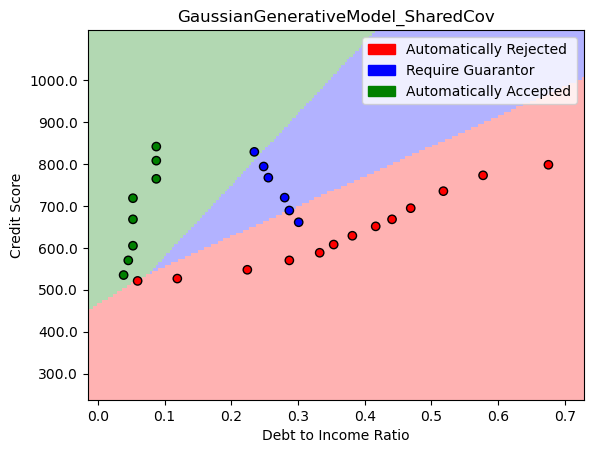

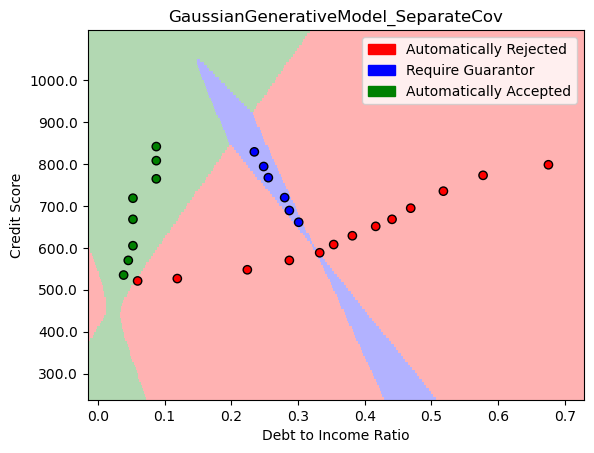

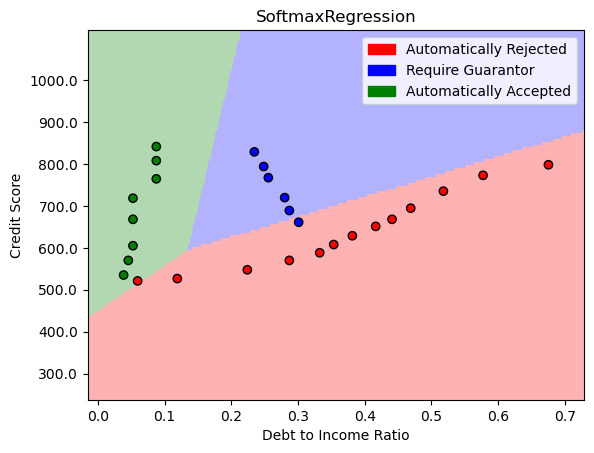

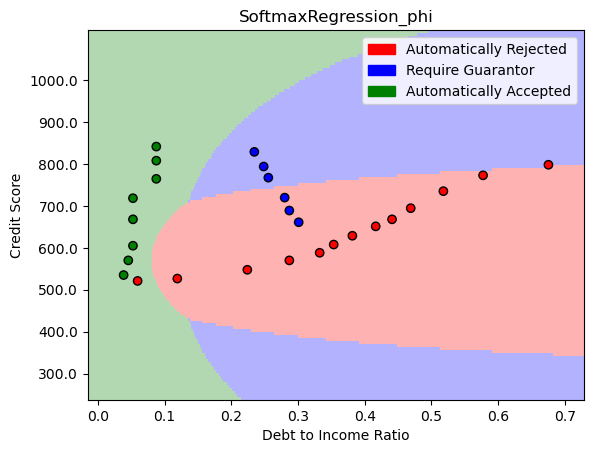

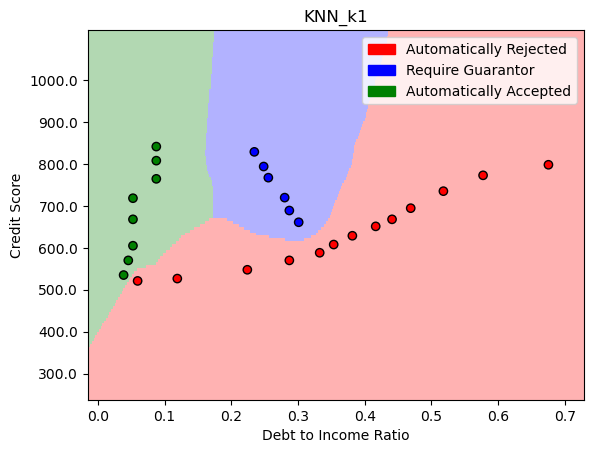

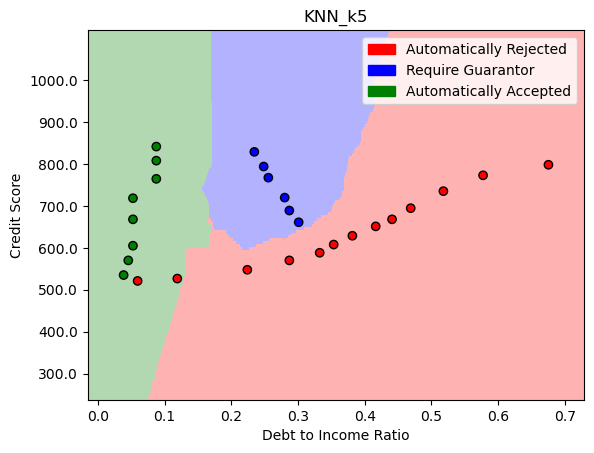

In [32]:
# Test Models

# GGM with shared covariance
model_shared = GaussianGenerativeModel(is_shared_covariance=True)
model_shared.fit(X_applicants, y_applicants)
visualize_boundary(model_shared, X_applicants, y_applicants, "GaussianGenerativeModel_SharedCov")

# GGM with separate covariance
model_separate = GaussianGenerativeModel(is_shared_covariance=False)
model_separate.fit(X_applicants, y_applicants)
visualize_boundary(model_separate, X_applicants, y_applicants, "GaussianGenerativeModel_SeparateCov")

# SoftmaxRegression (standard multi-class logistic regression)
softmax_model = SoftmaxRegression(eta=0.001, lam=0.001, verbose=False)
softmax_model.fit(X_applicants, y_applicants)
visualize_boundary(softmax_model, X_applicants, y_applicants, "SoftmaxRegression")

# SoftmaxRegression with additional feature map phi
softmax_phi_model = SoftmaxRegression(eta=0.001, lam=0.001, verbose=False)
softmax_phi_model.fit(phi(X_applicants), y_applicants)  # Train on transformed features
visualize_boundary(softmax_phi_model, X_applicants, y_applicants, "SoftmaxRegression_phi", basis=phi)

# KNNClassifier with k=1
knn1 = KNNClassifier(k=1)
knn1.fit(X_applicants, y_applicants)
visualize_boundary(knn1, X_applicants, y_applicants, "KNN_k1")

# KNNClassifier with k=5
knn5 = KNNClassifier(k=5)
knn5.fit(X_applicants, y_applicants)
visualize_boundary(knn5, X_applicants, y_applicants, "KNN_k5")

## Problem 3, Subpart 2

In [33]:
# Predicting for new applicant
point = transform(np.array([(0.32, 350)]))
print ("Transformed point", point)

pred_class_softmax = softmax_model.predict(point)
pred_proba_softmax = softmax_model.predict_proba(point)
print("Softmax Regression prediction:", pred_class_softmax)
print("Softmax Regression probabilities:", pred_proba_softmax)

point_phi = phi(point)
pred_class_softmax_phi = softmax_phi_model.predict(point_phi)
pred_proba_softmax_phi = softmax_phi_model.predict_proba(point_phi)
print("Softmax Regression with phi prediction:", pred_class_softmax_phi)
print("Softmax Regression with phi probabilities:", pred_proba_softmax_phi)

Transformed point [[ 1.64285714 -1.57142857]]
Softmax Regression prediction: [0]
Softmax Regression probabilities: [[9.99999653e-01 3.47070714e-07 2.82260310e-10]]
Softmax Regression with phi prediction: [1]
Softmax Regression with phi probabilities: [[0.2538532  0.65886064 0.08728616]]
